In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [2]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [5]:
n1 = 5
Q1 = np.array([
    [8, 2, 3, 4, 5],
    [2, 7, 2, 3, 4],
    [3, 2, 6, 2, 3],
    [4, 3, 2, 5, 2],
    [5, 4, 3, 2, 9]
])
weights1 = np.array([2, 3, 4, 5, 9])
capacity1 = 10

Q = torch.tensor(Q1, dtype=torch.float64)
weights = torch.tensor(weights1, dtype=torch.float64)
capacity = capacity1
dim = n1

weights_torch = weights / capacity

In [6]:
torch.linalg.eigh(Q)[0]

tensor([ 1.0601,  4.0366,  4.7886,  5.5120, 19.6028], dtype=torch.float64)

In [17]:
potential = lambda x: -torch.einsum('ni,ij,nj->n', x, Q, x)
isvalid = lambda x: (x @ weights_torch <= 1)

def regularized_potential(x):
    with torch.no_grad():
        a, _ = torch.max(x, axis=-1)
    
    exp_x = torch.exp(x - a[:, None])
    
    z = exp_x / (torch.exp(-a) + exp_x @ weights_torch)[:, None]
    # z = torch.exp(x - a[:, None] - torch.log(torch.exp(-a) + exp_x @ weights_torch)[:, None])
    with torch.no_grad():
        mask = torch.round(z).to(torch.float64)
        # mask = isvalid(torch.round(z)).to(torch.float64)
    
    vals = potential(z) - (x).sum(axis=-1) \
                + (dim + 1) * torch.log(torch.exp(-a) + exp_x @ weights_torch)
    return vals

In [18]:
num_particles = 10
particles = np.random.randn(*(num_particles, dim)) * 0.1
particles = torch.tensor(-particles, dtype=torch.float64, requires_grad=True)
h = 0.001
counter = 2

In [19]:
# particles

In [20]:
a, _ = torch.max(particles, axis=-1)
exp_x = torch.exp(particles - a[:, None])
z = exp_x / (torch.exp(-a) + exp_x @ weights_torch)[:, None]

In [21]:
z @ weights_torch

tensor([0.6957, 0.6921, 0.7069, 0.7088, 0.6934, 0.6889, 0.7057, 0.7261, 0.7146,
        0.6892], dtype=torch.float64, grad_fn=<MvBackward0>)

In [22]:
C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [23]:
capacity

10

In [24]:
weights_torch.min()

tensor(0.2000, dtype=torch.float64)

In [25]:
torch.sigmoid(particles) @ weights_torch

tensor([1.1436, 1.1360, 1.1754, 1.1820, 1.1383, 1.1263, 1.1720, 1.2269, 1.1964,
        1.1264], dtype=torch.float64, grad_fn=<MvBackward0>)

In [28]:
best_val = np.inf
best_particle = None

num_iters = 1_000

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)

for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 1 * np.sin(i / 2000) ** 2 + 10
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        # torch.clip(particles, min=-1, max=1, out=particles)
        
        z = torch.sigmoid(particles)
        rounded_z = torch.round(z)
        mask = isvalid(rounded_z)
        
        if mask.sum() > 0:
            rounded_vals = potential(rounded_z[mask])
            rounded_history[i] = rounded_vals.min()
        else:
            rounded_history[i] = best_val
        
        history[i] = vals.min()
        C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = particles[mask][jj].detach().clone()
            best_val = rounded_history[i]
    
    counter += 1
    particles.grad.zero_()

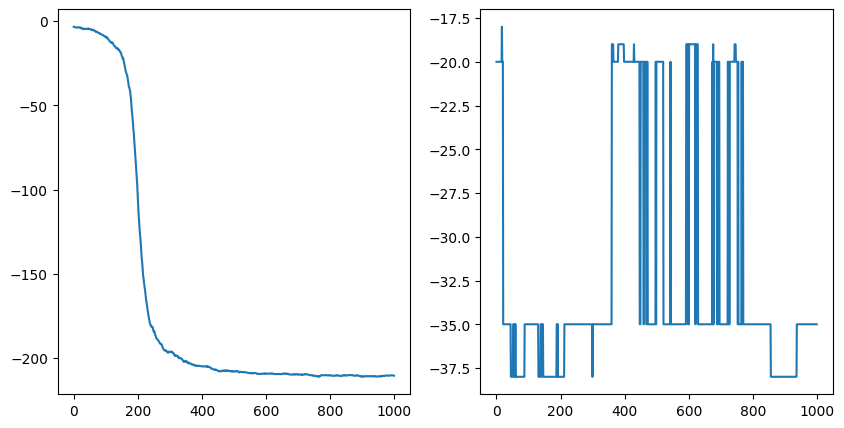

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [31]:
rounded_history.min()

tensor(-38., dtype=torch.float64)

In [123]:
potential = lambda x: -torch.einsum('...i,ij,...j', x, Q, x)
isvalid = lambda x: (x >= 0).all(axis=-1) * (x <= 1).all(axis=-1) * (x @ weights <= capacity)

K = 0
def regularized_potential(x):
    with torch.no_grad():
        mask = isvalid(torch.round(x)).to(torch.float64)
    
    vals = potential(x)
    return mask * vals \
            + 10 * (1 - mask) * (torch.max(torch.tensor(0), x @ weights - capacity)) ** 2 \
            + 10 * (1 - mask) * (torch.max(torch.tensor(0), -particles) ** 2).sum(axis=-1) \
            + 10 * (1 - mask) * (torch.max(torch.tensor(0), particles - 1) ** 2).sum(axis=-1)

In [124]:
num_particles = 10
particles = np.random.normal(0, 0.1, (num_particles, dim))
particles = torch.tensor(particles, dtype=torch.float64, requires_grad=True)

counter = 2

In [125]:
h = 0.01

In [126]:
best_val = np.inf
best_particle = None

num_iters = 5000
counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 10 * np.sin(i / 1000) ** 2 + 1
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_vals = regularized_potential(rounded_particles)
        history[i] = vals.min()
        rounded_history[i] = rounded_vals.min()
    
        # C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = rounded_particles[jj].detach().clone()
            best_val = rounded_history[i]
    
    counter += 1
    particles.grad.zero_()

In [127]:
rounded_history.min()

tensor(-38., dtype=torch.float64)

In [128]:
history.min()

tensor(-87.1383, dtype=torch.float64)

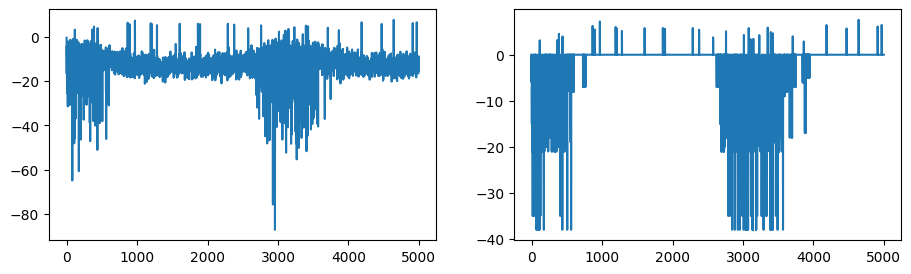

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [130]:
best_particle

tensor([1., 1., -0., 1., -0.], dtype=torch.float64)

In [131]:
potential(best_particle)

tensor(-38., dtype=torch.float64)

In [132]:
best_particle @ weights

tensor(10., dtype=torch.float64)

In [133]:
isvalid(best_particle)

tensor(True)